<a href="https://colab.research.google.com/github/yvesheri4/short-pulse-electron-beam-python/blob/main/Paper4_drift_space_9_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper 4 - Space charge effects in drift space

____

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.datasets import load_iris
import os
import pandas as pd
from glob import glob
import seaborn as sns

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from matplotlib.ticker import MaxNLocator

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import constants
import seaborn as sns
eps_0 = constants.epsilon_0
from matplotlib import cm
# import scienceplots
import matplotlib.pyplot as plt
import matplotlib as mpl

# plt.style.use(['no-latex'])

size = 24
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

### Particles

In [4]:
import numpy as np
from scipy import constants as cst

# Define the particle class
class Particle:
    def __init__(self, mass,charge, index):
        self.mass = mass
        self.i = index
        self.charge = charge
        self.r = np.zeros((1), dtype='float64')
        self.v = np.zeros((1), dtype='float64')

    def initPos(self, x):
        self.r = x

    def initSpeed(self, vx):
        self.v = vx

    def Heri_push(self, dt, E):
        temp = self.v
        self.v += 0.75*E*dt
        self.r += 1.5*(self.v+temp)*dt/2

### Functions

#### Particles related functions

In [5]:
def Create_Particle_list(mass,charge):
    List = []
    for i in range(len(charge)):
        List.append(Particle(mass[i],charge[i],i+1))
    return List

def Init_Particle_list(List,InitPos,InitSpeed):
    for i in range(len(List)):
        List[i].initPos(InitPos[i])
        List[i].initSpeed(InitSpeed[i])
    return List


#### Fields related functions

In [6]:
def Electric_Field(List,V0,d,t,Dt):
    N_inj = 1+int(t/Dt)
    if N_inj > len(List):
        N_inj = len(List)
    E = np.zeros(len(List))
    sum1 = 0
    List2 = []
    for j in range(N_inj):
        if List[j].r < 1 and List[j].r >=0:
            sum1 += (List[j].charge*List[j].r)
            List2.append(List[j])
    for j in range(len(List2)):
        sum2 = 0
        for i in range(j):
            sum2 += List2[i].charge
        E[List2[j].i-1] = (sum1 - sum2 - 0.5*List2[j].charge)
    return E

def Current_density(Vel,rho):

    len_t = Vel.shape[0]
    N_sheet = Vel.shape[1]
    J = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            sum1 += 1.5*Vel[i][j]*rho[j]
        J[i] = sum1

    return J

#### Simulations related

In [7]:
def Simulation(t_sim,Sys_Params,InitCond,k=100):

    time = np.linspace(0,t_sim,k)
    dt = time[1]-time[0]

    InitPos,InitSpeed = InitCond
    Dt,mass,charge,V0,d = Sys_Params

    List_part = Create_Particle_list(mass,charge)

    List_part = Init_Particle_list(List_part,InitPos,InitSpeed)
#     print(List_part[0].r)

    position = np.zeros([len(time),len(List_part)])
    velocity = np.zeros([len(time),len(List_part)])
    E_field = np.zeros([len(time),len(List_part)])

    count = 0

    for t in time:
        E = Electric_Field(List_part,V0,d,t,Dt)
        E_field[count] = E

        N_inj = 1+int(t/Dt)
        if N_inj > len(List_part):
            N_inj = len(List_part)

        for j in range(N_inj):
            position[count][j] = List_part[j].r
            velocity[count][j] = List_part[j].v

            if List_part[j].r < 1 and List_part[j].r >= 0:
                List_part[j].Heri_push(dt,E[j])
            else:
                List_part[j].v = 0
        count += 1
    return position,velocity,E_field

def distorsion(position,time,Dt,M):
    t_init = Dt*(M-1)
    i = 0
    while  position[i,0] < 1:
        i +=1
    j = 0
    while  position[j,-1] < 1:
        j +=1
    t_final = time[j] - time[i]
    Distorsion = t_final / t_init
    return Distorsion

def Norm_J_crit_s(X):
    t1 = (2/X**3)
    t2 = (3/4)*X**2
    return t1*(1-np.sqrt(1-t2))

def Norm_J_crit_e(X):
    t1 = (16/(27*X**3))
    t2 = (27/16)*X**2
    return t1*(1-np.sqrt(1-t2))

def limit_charge(T0,Params_sys,ini_conds,iterations):
    tol = 1e-3
    Indicator = False
    position,velocity,E_field = Simulation(T0,Params_sys,ini_conds,iterations)
    if (abs(position[-1,:] - position[0,:]) < tol ).any():
        Indicator = True
    return Indicator

# def sheets_spacing(mass,) = lambda e,E,m,dt: 0.5*(e*E/m)*(dt**2)

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e)))

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

#### Plots

In [8]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 5000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=1,label=f"$\\rho/\\rho^*$ = {int(100*(j+1)*0.25)}%")
#             plt.plot(shape[0],shape[1],lw=5,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.legend(fontsize=8)
            plt.xlim(0,1)
        ######################################################


            K = np.array([0])
            A = np.array([1])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
            plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=1)
#             plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

        ######################################################

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=1)
#             plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=.3)

#         plt.savefig(f'snapshots_sq{j}.jpg', dpi=400)
        plt.show()

In [ ]:
# position_sq.shape

____

In [9]:
def gaussian_profile(tp,M):
  sig2 = tp **2/np.log(256)
  sig = np.sqrt(sig2)
  t = np.linspace(-3.5*sig, 3.5*sig, M)
  prof_ = np.exp(-0.5*((t)**2) /sig2 )
  prof_ /= np.sum(prof_)
  return prof_

def trapezoid_profile(tp,M):
  start_time = 0
  rise_time = 0.15*tp
  fall_time = 0.15*tp

  # End time of the trapezoidal pulse
  end_time = start_time + rise_time + tp + fall_time

  t = np.linspace(0, end_time, M)

  # Initialize the pulse array
  pulse = np.zeros_like(t)

  # Calculate indices for rise, top, and fall segments
  rise_end = start_time + rise_time
  top_end = rise_end + tp
  fall_start = top_end
  fall_end = fall_start + fall_time

  # Rise segment
  pulse[(t >= start_time) & (t < rise_end)] = (
       (t[(t >= start_time) & (t < rise_end)] - start_time) / rise_time
  )
  # Top segment (FWHM width)
  pulse[(t >= rise_end) & (t < top_end)] = 1

  # Fall segment
  pulse[(t >= fall_start) & (t < fall_end)] = (
       (1 - ((t[(t >= fall_start) & (t < fall_end)] - fall_start) / fall_time))
  )
  return pulse / np.sum(pulse)

Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)

def pulse_profile(tp,M,Type = 'square'):
    Type = Type.lower()
    if Type == 'square':
        return np.ones(M)/M
    if Type == 'gauss':
        return gaussian_profile(tp,M)
    if Type == 'trapezoidal':
        return trapezoid_profile(tp,M)
    else:
        return print('Profile not recognized')

# Injection Simulation

## Parameters

In [94]:
V0 = 30e3
d = 1.5e-3
M = 200
Tcl = Time_CL(V0,d)
kp = .1
fp = 1
tpulse = kp*30e-12     # Full Width at Half Maximum
t0 = tpulse/2       # Center of the pulse

iterations = 5000
Dt = kp/M

Alpha = 1.03

ini_pos = np.zeros(M)
ini_speed = Alpha*np.ones(M)
ini_conds = [ini_pos,ini_speed]
time = np.linspace(0, 4,iterations)

In [95]:
Tcl

4.38052526525465e-11

In [96]:
#_______________________________
plt.rc('font', family='serif')
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
color_ga = fp*Ga_charge
norm = mpl.colors.Normalize(vmin=color_ga.min(), vmax=color_ga.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

## 1. Trajectories

### 1.1 Square-top

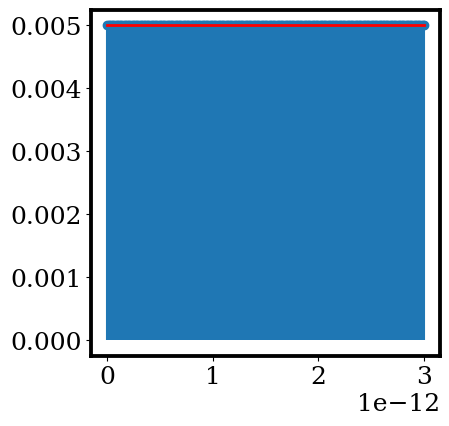

In [97]:
Sq_charge = pulse_profile(tpulse,M)
Sq_mass = pulse_profile(tpulse,M)
t = np.linspace(0,tpulse,M)
plt.stem(t,Sq_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Sq_mass,'r',lw=2)

Sq_Params_sys = [Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

In [98]:
position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

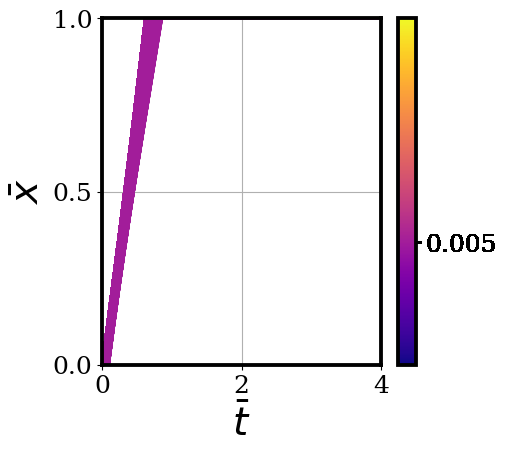

In [99]:
color_sq = fp*Sq_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_sq[:,:i], lw=1.5,c=cmap.to_rgba(color_sq[i]))
fig.colorbar(cmap, ticks=color_sq)

plt.xlim(0.,4)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
plt.ylabel('$\\bar{x}$',fontsize=28)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.grid()
# plt.text(1.5, 0.88, '(a)', fontsize=26)
# plt.savefig('position_sq.png',bbox_inches='tight', dpi=300)
plt.show()

In [100]:
min(position_sq[-1,:]-position_sq[0,:])

1.0000019720011732

In [101]:
# for i in range(M):
#   print('sheet',i)
#   plt.plot(time, position_sq[:,i], lw=2,c=cmap.to_rgba(color_sq[i]))
#   plt.show()

### 1.2 Trapezoidal

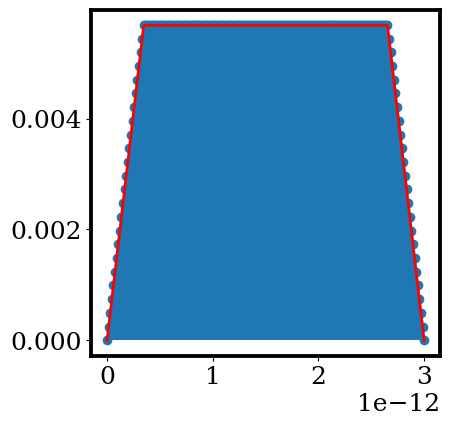

In [102]:
Tr_charge = pulse_profile(tpulse,M,Type = 'trapezoidal')
Tr_mass = pulse_profile(tpulse,M,Type = 'trapezoidal')
t = np.linspace(0,tpulse,M)
plt.stem(t,Tr_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Tr_mass,'r',lw=2)

Tr_Params_sys = [Dt,fp*Tr_mass,fp*Tr_charge,V0,d]

In [103]:
position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

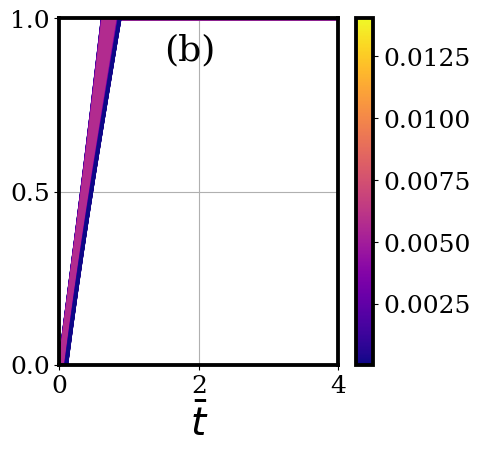

In [104]:
color_tr = fp*Tr_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_tr[:,i], lw =2.5, c=cmap.to_rgba(color_tr[i]))
fig.colorbar(cmap)

plt.xlim(0,4)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
# plt.ylabel('$\\bar{x}$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.grid()
plt.text(1.5, 0.88, '(b)', fontsize=26)
# plt.savefig('position_tr.png',bbox_inches='tight', dpi=300)
plt.show()

In [105]:
min(position_tr[-1,:]-position_tr[0,:])

1.0000030823461064

In [106]:
# for i in range(M):
#   print('sheet',i)
#   plt.plot(time, position_tr[:,i], lw=2,c=cmap.to_rgba(color_sq[i]))
#   plt.show()

### 1.3 Gaussian

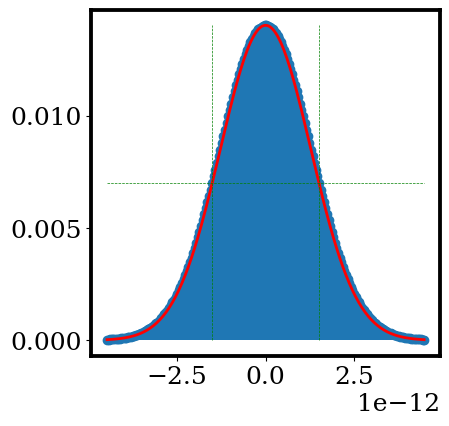

In [107]:
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
Ga_mass = pulse_profile(tpulse,M,Type = 'gauss')
sig2 = tpulse **2/np.log(256)
sig = np.sqrt(sig2)
t = np.linspace(-3.5*sig, 3.5*sig, M)
plt.stem(t,Ga_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Ga_mass,'r',lw=2)
plt.vlines(-tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.vlines(tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.hlines(max(Ga_mass)/2, -3.5*sig,3.5*sig, 'g','--',lw=0.5)

Ga_Params_sys = [Dt,fp*Ga_mass,fp*Ga_charge,V0,d]

In [108]:
position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

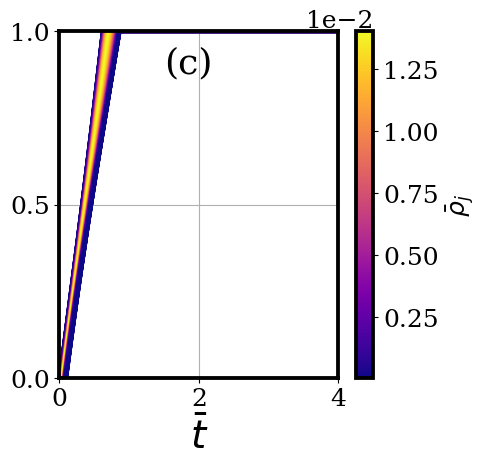

In [109]:
color_ga = fp*Ga_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_ga[:,i],lw=2.5, c=cmap.to_rgba(color_ga[i]))
cbar = fig.colorbar(cmap,label='$\\bar{\\rho}_j$')
cbar.formatter.set_powerlimits((0, 0))
plt.xlim(0,4)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
# plt.ylabel('$\\bar{x}$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.grid()
plt.text(1.5, 0.88, '(c)', fontsize=26)
# plt.savefig('position_ga.png',bbox_inches='tight', dpi=300)
plt.show()

In [110]:
min(position_ga[-1,:]-position_ga[0,:])

1.0000128094852094

Compare head and rear sheets


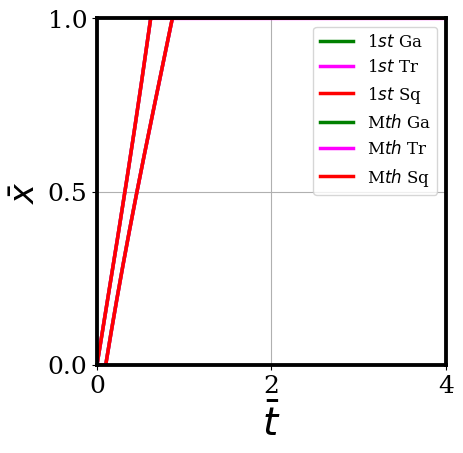

In [111]:
plt.plot(time, position_ga[:,0],color ='green' ,lw=2.5, label='1$st$ Ga')
plt.plot(time, position_tr[:,0],color ='magenta' ,lw=2.5, label='1$st$ Tr')
plt.plot(time, position_sq[:,0],color ='red' ,lw=2.5, label='1$st$ Sq')

plt.plot(time, position_ga[:,-2],color ='green', lw=2.5, label='M$th$ Ga')
plt.plot(time, position_tr[:,-1],color ='magenta' ,lw=2.5, label='M$th$ Tr')
plt.plot(time, position_sq[:,-1],color ='red' ,lw=2.5, label='M$th$ Sq')

plt.xlim(0,4)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
plt.ylabel('$\\bar{x}$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.grid()
plt.legend(fontsize=12)
# plt.text(1.5, 0.88, '(c)', fontsize=26)
# plt.savefig('position_ga.png',bbox_inches='tight', dpi=300)
plt.show()

## 2. Current density

### 2.1 Square-top

In [112]:
Dt = 1/M
k = [1e-3,1e-2,0.1,1]
J_sq_l = []
for i in range(len(k)):
  Sq_Params_sys = [k[i]*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]
  position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)
  J_sq_l.append(Current_density(velocity_sq,Sq_charge))

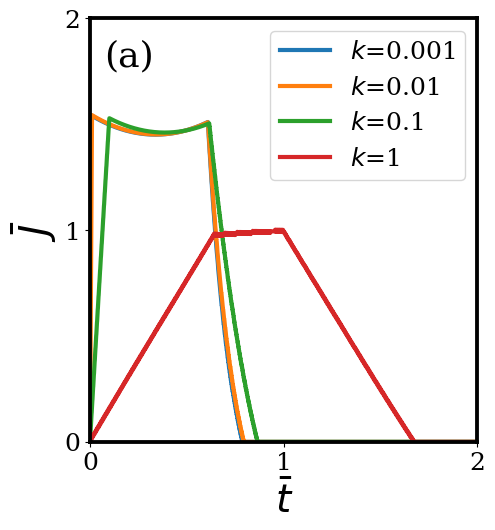

In [113]:
plt.figure(figsize=(5,5.5))
plt.text(0.075, 1.775, '(a)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(k)):
  plt.plot(time,J_sq_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.ylim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=28)
  plt.legend(fontsize=18)
  plt.locator_params(axis='y', nbins=3)
  plt.locator_params(axis='x', nbins=3)

### 2.2 Trapezoidal

In [114]:
Dt = 1/M
k = [1e-3,1e-2,0.1,1]
J_tr_l = []
for i in range(len(k)):
  Tr_Params_sys = [k[i]*Dt,fp*Tr_mass,fp*Tr_charge,V0,d]
  position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)
  J_tr_l.append(Current_density(velocity_tr,Tr_charge))

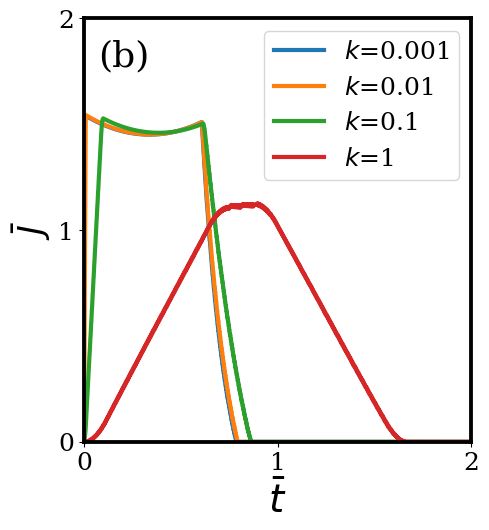

In [115]:
plt.figure(figsize=(5,5.5))
plt.locator_params(axis='y', nbins=3)
plt.text(0.075, 1.775, '(b)', fontsize=26)

for i in range(len(k)):
  plt.plot(time,J_tr_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=24)
  plt.ylim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.legend(fontsize=18)
  plt.locator_params(axis='x', nbins=3)

### 2.3 Gaussian

In [116]:
Dt = 1/M
k = [1e-3,1e-2,0.1,1]
J_ga_l = []
for i in range(len(k)):
  Ga_Params_sys = [k[i]*Dt,fp*Ga_mass,fp*Ga_charge,V0,d]
  position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)
  J_ga_l.append(Current_density(velocity_ga,Ga_charge))

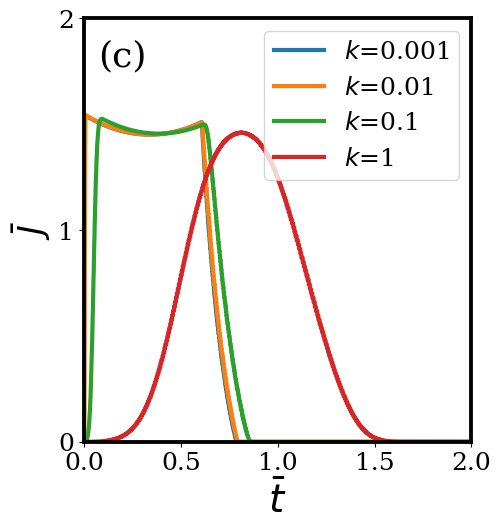

In [117]:
plt.figure(figsize=(5,5.5))
plt.text(0.075, 1.775, '(c)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(k)):
  plt.plot(time,J_ga_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.ylim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=24)
  plt.locator_params(axis='y', nbins=3)
  plt.legend(fontsize=18)

## 3. Evolution Snapshots

In [118]:
size = 18
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [119]:
fp = 1
kp = .1
Dt = kp/M

In [120]:
charge_mult = []
mass_mult = []
charge_mult.append(fp*Sq_charge)
charge_mult.append(fp*Tr_charge)
charge_mult.append(fp*Ga_charge)
mass_mult.append(fp*Sq_mass)
mass_mult.append(fp*Tr_mass)
mass_mult.append(fp*Ga_mass)

In [121]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(4,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

____

# PIC Results

In [122]:
def read_text_files2(folder_path):
    # Initialize a dictionary to save the name and value of each DataFrame
    dict_df = {}

    # Iterate through all files and subdirectories in the given folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file starts with 'e' and has a .txt extension
            if file.startswith('u') and file.endswith('.txt'):
                # Construct the file path
                file_path = os.path.join(root, file)

                # Extract subfolder and subsubfolder names
                subfolder_name = os.path.basename(os.path.dirname(root))
                subsubfolder_name = os.path.basename(os.path.dirname(file_path))

                # Create a unique DataFrame name
                df_name = f"{subfolder_name}_{subsubfolder_name}_{os.path.splitext(file)[0]}"

                # Define custom column names
                column_names = ['p', 'u']

                # Read the text file into a DataFrame, skipping the first line and using custom column names
                df = pd.read_csv(file_path, delimiter='\t\t', skiprows=2, names=column_names)

                # Define the values to be dropped
                values_to_drop = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 46, 46.5, 47, 47.5, 48, 48.5, 49, 49.5, 50]

                # Drop rows where 'p' column matches the specified values
                df = df[~df['p'].isin(values_to_drop)]

                # Assign the DataFrame to the dynamically generated name
                globals()[df_name] = df

                # Save the DataFrame and its name to the dictionary
                dict_df[df_name] = df

                # Print information about the loaded DataFrame
                print(f"Loaded DataFrame '{df_name}' from '{file_path}'")

    # Return the dictionary containing DataFrame names and values
    return dict_df

In [123]:
# Example usage:
# folder_path = '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space'
folder_path = '/content/drive/MyDrive/Research/PIC/NewPIC/drift'
dict_df = read_text_files2(folder_path)

Loaded DataFrame 'drift_s_uyy3' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/s/uyy3.txt'
Loaded DataFrame 'drift_s_uyy4' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/s/uyy4.txt'
Loaded DataFrame 'drift_s_uyy1' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/s/uyy1.txt'
Loaded DataFrame 'drift_s_uyy2' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/s/uyy2.txt'
Loaded DataFrame 'drift_g_uyy4' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/g/uyy4.txt'
Loaded DataFrame 'drift_g_uyy3' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/g/uyy3.txt'
Loaded DataFrame 'drift_g_uyy1' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/g/uyy1.txt'
Loaded DataFrame 'drift_g_uyy2' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/g/uyy2.txt'
Loaded DataFrame 'drift_t_uyy4' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/t/uyy4.txt'
Loaded DataFrame 'drift_t_uyy1' from '/content/drive/MyDrive/Research/PIC/NewPIC/drift/t/uyy1.txt'
Loaded Dat

In [124]:
# dict_df

In [125]:
v = np.sqrt(2*V0*cst.e/cst.m_e)

In [126]:
u1s = dict_df['drift_s_uyy1']
u1t = dict_df['drift_t_uyy1']
u1g = dict_df['drift_g_uyy1']
# u1cst = dict_df['drift_cst_uyy1']
# print(u1)

(0.0, 1.0)

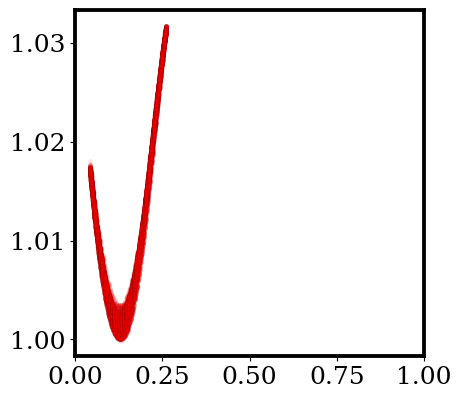

In [127]:
snap1_vels = np.array(u1s['u']/v)
snap1_poss = np.array(u1s['p']/1.5e-3)
plt.scatter(snap1_poss[::3],snap1_vels[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

(0.0, 1.0)

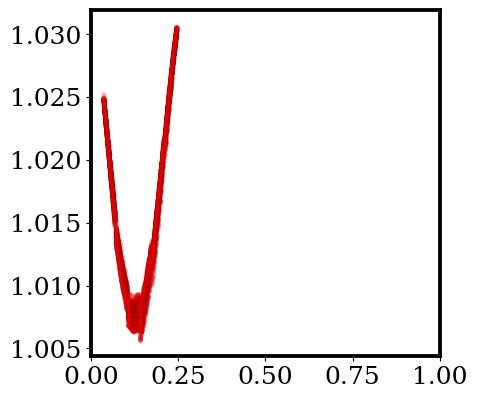

In [128]:
snap1_velt = np.array(u1t['u']/v)
snap1_post = np.array(u1t['p']/1.5e-3)
plt.scatter(snap1_post[::3],snap1_velt[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

(0.0, 1.0)

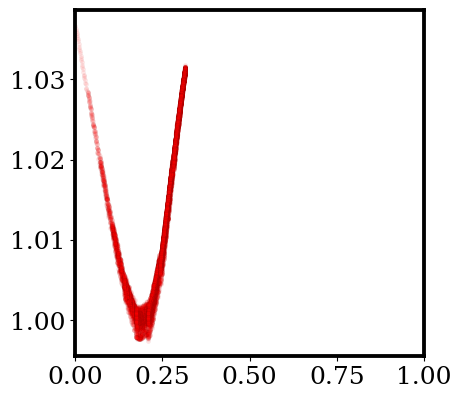

In [129]:
snap1_velg = np.array(u1g['u']/v)
snap1_posg = np.array(u1g['p']/1.5e-3)
plt.scatter(snap1_posg[::3],snap1_velg[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

In [130]:
# snap1_velcst = np.array(u1cst['u']/v)
# snap1_poscst = np.array(u1cst['p']/1.5e-3)
# plt.scatter(snap1_posg[::3],snap1_velg[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
# plt.xlim(0,1)

In [131]:
u2s = dict_df['drift_s_uyy2']
u2t = dict_df['drift_t_uyy2']
u2g = dict_df['drift_s_uyy2']
# print(u2)

(0.0, 1.0)

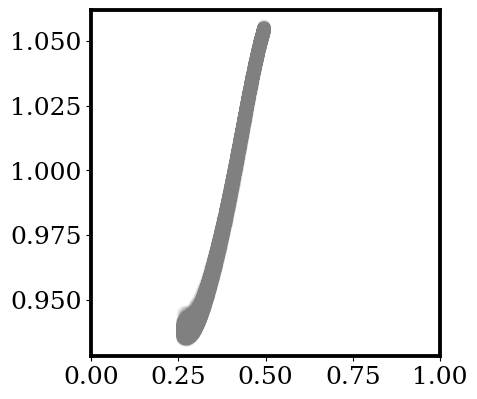

In [132]:
snap2_vels = np.array(u2s['u']/v)
snap2_poss = np.array(u2s['p']/1.5e-3)
plt.scatter(snap2_poss,snap2_vels, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

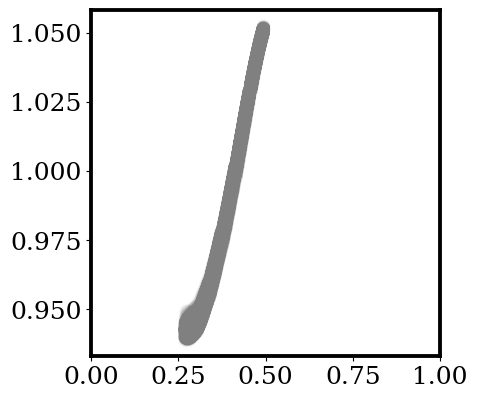

In [133]:
snap2_velt = np.array(u2t['u']/v)
snap2_post = np.array(u2t['p']/1.5e-3)
plt.scatter(snap2_post,snap2_velt, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

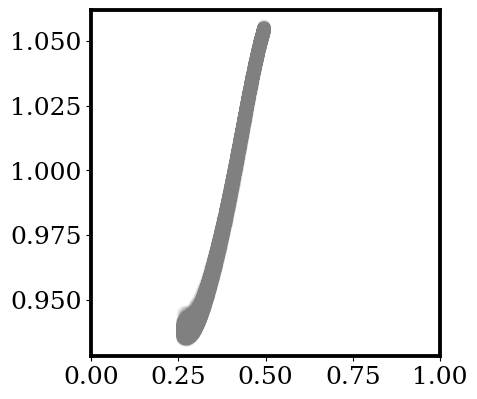

In [134]:
snap2_velg = np.array(u2g['u']/v)
snap2_posg = np.array(u2g['p']/1.5e-3)
plt.scatter(snap2_posg,snap2_velg, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

In [135]:
u3s = dict_df['drift_s_uyy3']
u3t = dict_df['drift_t_uyy3']
u3g = dict_df['drift_g_uyy3']
# print(u2)

(0.0, 1.0)

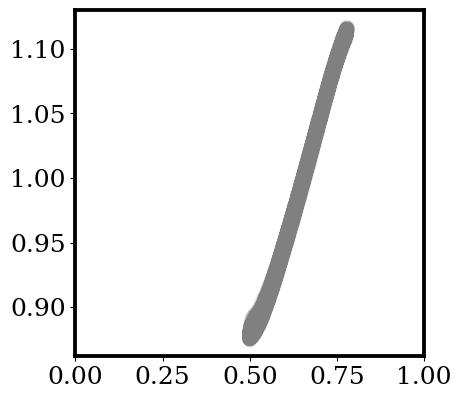

In [136]:
snap3_vels = np.array(u3s['u']/v)
snap3_poss = np.array(u3s['p']/1.5e-3)
plt.scatter(snap3_poss,snap3_vels, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

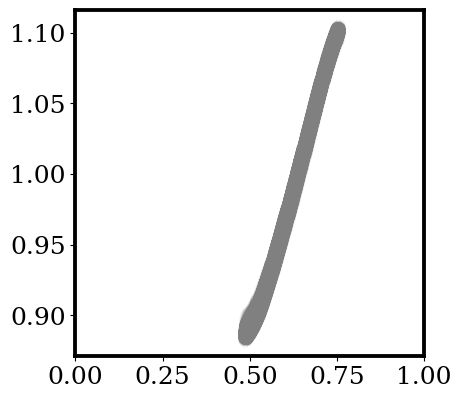

In [137]:
snap3_velt = np.array(u3t['u']/v)
snap3_post = np.array(u3t['p']/1.5e-3)
plt.scatter(snap3_post,snap3_velt, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

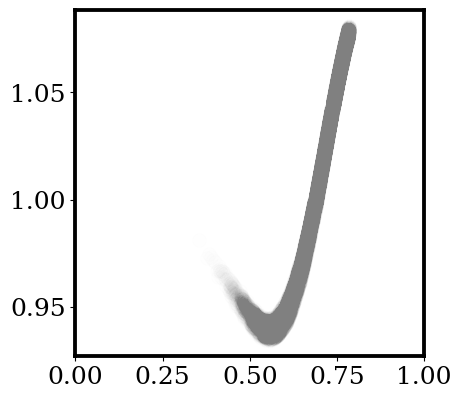

In [138]:
snap3_velg = np.array(u3g['u']/v)
snap3_posg = np.array(u3g['p']/1.5e-3)
plt.scatter(snap3_posg,snap3_velg, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

In [139]:
df_CST = pd.read_csv('/content/drive/MyDrive/Research/PIC/NewPIC/drift/cst/uyy1.csv')
snap1_poscst = df_CST['Column2']/1.5
snap1_velcst = 1.*df_CST['Column3']/v

In [140]:
# snap1_poscst

,Column2
0,0.051624
1,0.051624
2,0.051625
3,0.051625
4,0.051625
...,...
845315,0.249804
845316,0.249804
845317,0.249805
845318,0.249805


In [141]:
df_CST = pd.read_csv('/content/drive/MyDrive/Research/PIC/NewPIC/drift/cst/uyy2.csv')
snap2_poscst = df_CST['Column2']/1.5
snap2_velcst = 1.*df_CST['Column3']/v

In [142]:
df_CST = pd.read_csv('/content/drive/MyDrive/Research/PIC/NewPIC/drift/cst/uyy3.csv')
snap3_poscst = df_CST['Column2']/1.5
snap3_velcst = 1.*df_CST['Column3']/v

In [143]:
PIC_phase_poss = [snap1_poss,snap2_poss,snap3_poss]
PIC_phase_vels = [snap1_vels,snap2_vels,snap3_vels]

PIC_phase_post = [snap1_post,snap2_post,snap3_post]
PIC_phase_velt = [snap1_velt,snap2_velt,snap3_velt]

PIC_phase_posg = [snap1_posg,snap2_posg,snap3_posg]
PIC_phase_velg = [snap1_velg,snap2_velg,snap3_velg]

PIC_phase_poscst = [snap1_poscst,snap2_poscst,snap3_poscst]
PIC_phase_velcst = [snap1_velcst,snap2_velcst,snap3_velcst]

In [148]:
def plots_shape_phase_mult(position, velocity, E_field, rho, n=2):
    prof = ['Square', 'Trapezoidal', 'Gaussian']
    lag = [230,400,585]
    len_rho = len(rho)
    for i in range(1, n+2):
        if i == n:
            lag = lag
        fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
        l = 2*(i-1)
        for j in range(len_rho):
            shape = np.array([position[j][lag[i-1]], rho[j]])
            phase = np.array([position[j][lag[i-1]], velocity[j][lag[i-1]]])
            axs[0].plot(shape[0], shape[1], lw=4, label=f"{prof[j]}")
            axs[0].set_ylabel("$\\bar{\\rho_j}$")
            axs[0].set_xlim(0, 1)
            # axs[0].set_ylim(0, .015)
            axs[0].locator_params(nbins=3)
            if i == 1:
                axs[0].legend(fontsize=13.5)
            if j == 0:
                axs[0].annotate(f'({chr(97 + l)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')
            axs[1].scatter(PIC_phase_poss[i-1][::100],PIC_phase_vels[i-1][::100],marker='o',s=25,linewidth=1,facecolors='royalblue',edgecolors='royalblue',alpha=1,label='XOOPIC Square-top')
            axs[1].scatter(PIC_phase_post[i-1][::100],PIC_phase_velt[i-1][::100],marker='o',s=25,linewidth=1,facecolors='orange',edgecolors='orange',alpha=1,label='XOOPIC Trapezoidal')
            axs[1].scatter(PIC_phase_posg[i-1][::100],PIC_phase_velg[i-1][::100],marker='o',s=25,linewidth=1,facecolors='forestgreen',edgecolors='forestgreen',alpha=1,label='XOOPIC Gaussian')
            axs[1].scatter(PIC_phase_poscst[i-1][::100],PIC_phase_velcst[i-1][::100],marker='o',s=25,linewidth=1,facecolors='red',edgecolors='red',alpha=1,label='CST')
            axs[1].plot(phase[0], phase[1], lw=4)
            axs[1].set_ylabel("$\\bar{v}$")
            axs[1].set_xlim(0, 1)
            axs[1].set_ylim(.825, 1.175)
            axs[1].locator_params(nbins=3)
            if i == 1:
              if j == 0:
                axs[1].legend(fontsize=13.5)
            if  j == 0:
                axs[1].annotate(f'({chr(97 + l+1)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')
            if i == n+1:
                axs[0].set_xlabel("$\\bar{x}$")
                axs[1].set_xlabel("$\\bar{x}$")
        axs[1].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        axs[0].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        fig.tight_layout(pad=.01)
        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

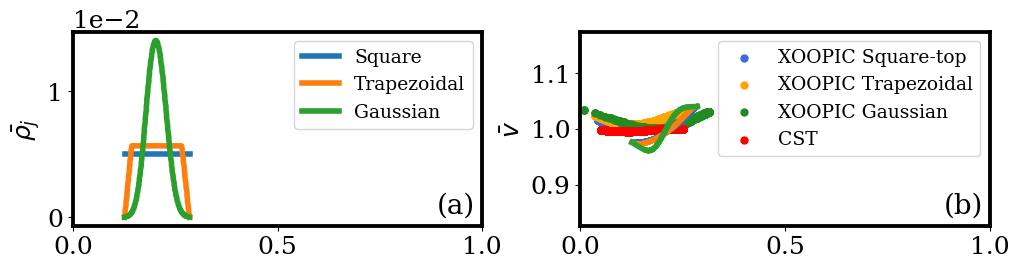

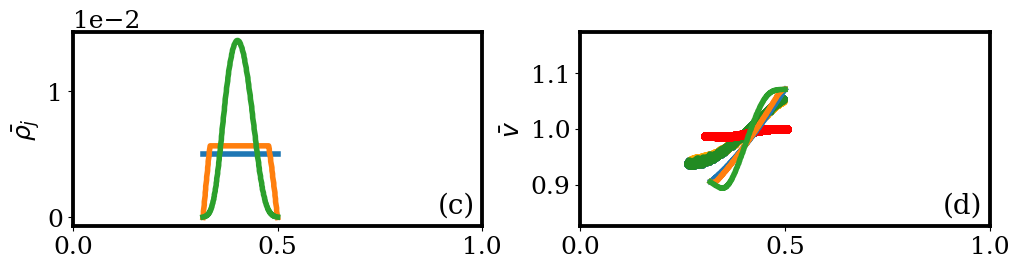

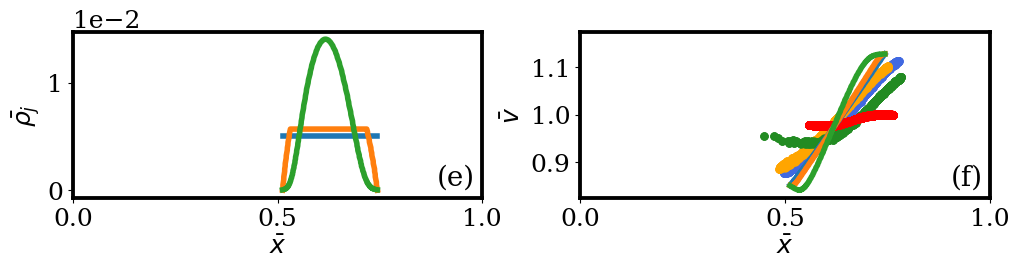

In [149]:
plots_shape_phase_mult(position_mult,velocity_mult,E_field_mult,charge_mult)

In [150]:
v/1e8

1.0272740658963886

In [151]:
def plots_shape_phase_mult2(position, velocity, E_field, rho, n=2):
    prof = ['Square', 'Trapezoidal', 'Gaussian']
    lag = [230,660,887]

    len_rho = len(rho)

    for i in range(1, n+2):
        if i == n:
            lag = lag

        fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))

        l = 2*(i-1)

        for j in range(len_rho):
            shape = np.array([position[j][lag[i-1]], rho[j]])
            phase = np.array([position[j][lag[i-1]], velocity[j][lag[i-1]]])

            axs[0].plot(shape[0], shape[1], lw=4, label=f"$f$ = {f[j]}")
            axs[0].set_ylabel("$\\bar{\\rho_j}$")
            axs[0].set_xlim(0, 1)
            axs[0].set_ylim(0, .015)
            axs[0].locator_params(nbins=3)

            if i == 1:
                axs[0].legend(fontsize=15.5)
            if j == 0:
                axs[0].annotate(f'({chr(97 + l)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            axs[1].plot(phase[0], phase[1], lw=4)
            axs[1].set_ylabel("$\\bar{v}$")
            axs[1].set_xlim(0, 1)
            axs[1].locator_params(nbins=3)

            if  j == 0:
                axs[1].annotate(f'({chr(97 + l+1)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            if i == n+1:
                axs[0].set_xlabel("$\\bar{x}$")
                axs[1].set_xlabel("$\\bar{x}$")

        axs[1].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        axs[0].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)

        fig.tight_layout(pad=.01)
        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

Text(0, 0.5, '$\\rho$')

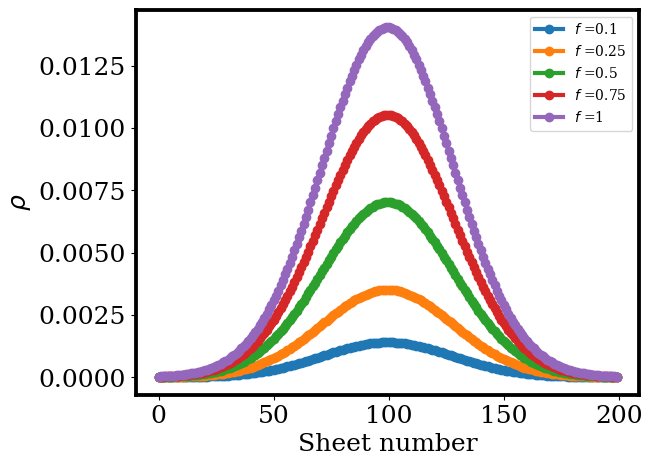

In [157]:
Ga_charge_mult2 = []
Ga_mass_mult2 = []
f = [0.1,0.25,.5,.75,1]

for i in range(5):
    Ga_charge_mult2.append(f[i]*pulse_profile(tpulse,M,'gauss'))
    Ga_mass_mult2.append(f[i]*pulse_profile(tpulse,M,'gauss'))

Ga_mass_mult2 = np.array(Ga_mass_mult2)
Ga_charge_mult2 = np.array(Ga_charge_mult2)

plt.figure(figsize=(6.5, 5))
for i in range(5):
    plt.plot(Ga_charge_mult2[i],'o-',lw=3,label=f"$f$ ={f[i]}")
    plt.legend(fontsize="10")

plt.xlabel('Sheet number')
plt.ylabel('$\\rho$')

In [160]:
position_g_mult2 = []
velocity_g_mult2 = []
E_field_g_mult2 = []

fp = 1
kp = .1
Dt = kp/M

for i in range(5):

    Ga_charge2 = Ga_charge_mult2[i]
    Ga_mass2 = Ga_mass_mult2[i]

    Ga_Params_sys2 = [Dt,Ga_mass2,Ga_charge2,V0,d]

    res_2 = Simulation(4,Ga_Params_sys2,ini_conds,iterations)

    position_g_mult2.append(res_2[0])
    velocity_g_mult2.append(res_2[1])
    E_field_g_mult2.append(res_2[2])

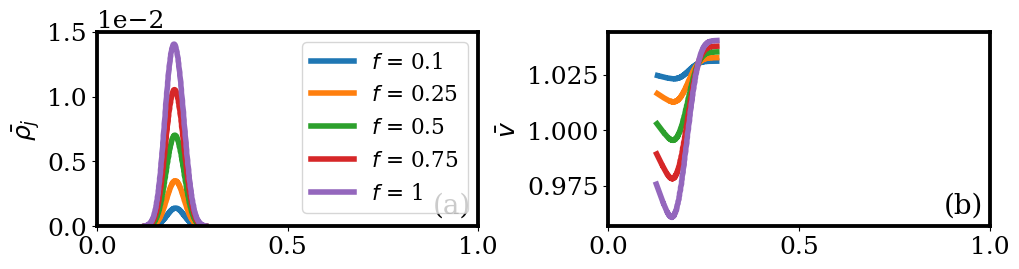

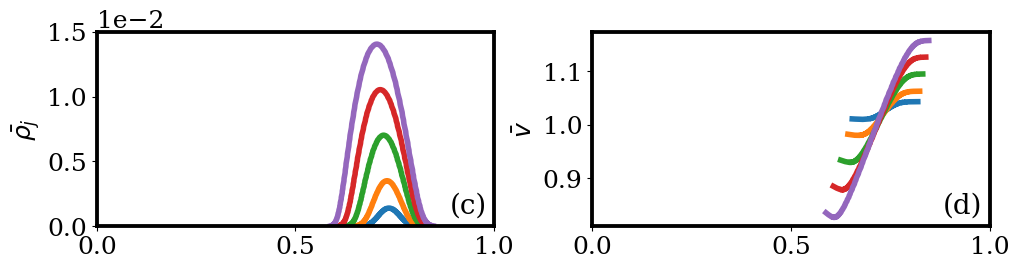

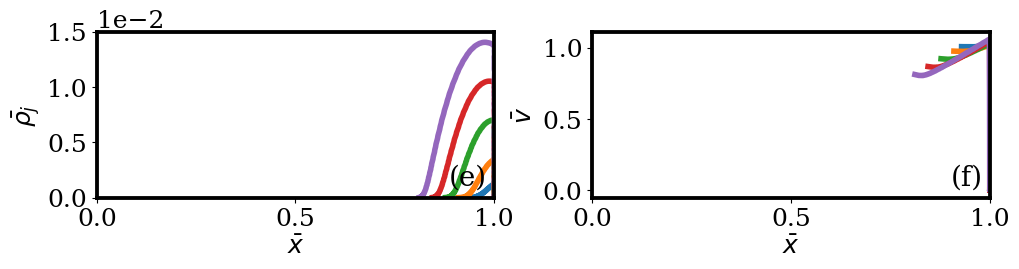

In [161]:
plots_shape_phase_mult2(position_g_mult2,velocity_g_mult2,E_field_g_mult2,Ga_charge_mult2)

### 1.5 Distorsion of the pulse

In [176]:
def th_distor(f,k):
  dist = ((3/4)*f**1)/k
  return dist

#### Distorsion with pulse length

The pulse charge is maintained at 100% and $v_0=1$

In [177]:
meanS = np.array([4.45454545, 2.35454545, 1.48181818, 1.22121212, 1.11818182])
meanT = np.array([4.63636364, 2.5       , 1.61363636, 1.34545455, 1.24545455])
meanG = np.array([3.36363636, 2.16363636, 1.90454545, 1.86060606, 1.76136364])

errorS = np.array([0.        , 0.        , 0.        , 0.00675721, 0.        ])
errorT = np.array([0.        , 0.        , 0.        , 0.00844652, 0.        ])
errorG = np.array([6.96373765e-16, 0., 0., 0., 0])

In [178]:
len(time)

5000

In [188]:
k_range = [1e-3,5e-3,1e-2,5e-2,1e-1,0.5]  # Pulse length range

# f_range = np.array([3., 3.2, 3.2, 3.2, 3.4, 4., 4.4, 4.8 , 5.4, 5.8 , 6.4])

fp = 2.8
Alpha = 1

In [189]:
distorsion_list_ga_k = np.zeros([2,len(k_range)])
distorsion_list_tr_k = np.zeros([2,len(k_range)])
distorsion_list_sq_k = np.zeros([2,len(k_range)])
# figure(figsize=(9, 4))

Dt = 1/M

for a in range(1,3):
  ini_pos = np.zeros(M)
  ini_speed = a*np.ones(M)
  ini_conds = [ini_pos,ini_speed]

  ind = 0
  for k in k_range:

      # fp = f_range[ind]
      Sq_Params_sys = [k*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]
      Tr_Params_sys = [k*Dt,fp*Tr_mass,fp*Tr_charge,V0,d]
      Ga_Params_sys = [k*Dt,fp*Ga_mass,fp*Ga_charge,V0,d]

      position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)
      position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)
      position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)

      distorsion_list_sq_k[a-1][ind] = distorsion(position_sq,time,k*Dt,M)
      distorsion_list_ga_k[a-1][ind] = distorsion(position_ga,time,k*Dt,M)
      distorsion_list_tr_k[a-1][ind] = distorsion(position_tr,time,k*Dt,M)

      ind +=1

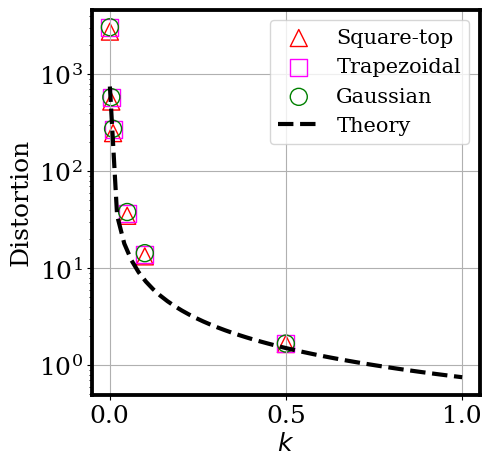

In [194]:
th = th_distor(1,np.linspace(1e-3,1))

plt.figure(figsize=(5, 5))
# For v = 1
#__________________________________________________________________________________
plt.scatter(k_range,distorsion_list_sq_k[0,:],marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(k_range,distorsion_list_tr_k[0,:],marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(k_range,distorsion_list_ga_k[0,:],marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')

# For v = 2
#___________________________________________________________________________________
# plt.scatter(k_range,distorsion_list_sq_k[1,:],marker='^',s=150,edgecolors='r',facecolors='r',label='Square-top')
# plt.scatter(k_range,distorsion_list_tr_k[1,:],marker='s',s=150,edgecolors='magenta',facecolors='magenta',label='Trapezoidal')
# plt.scatter(k_range,distorsion_list_ga_k[1,:],marker='o',s=150,edgecolors='g',facecolors='g',label='Gaussian')

plt.plot(np.linspace(1e-3,1),th,'--',color='black',markerfacecolor='None',lw=3,label='Theory')

#__________________________________________________________________________________
# plt.errorbar(k_range, meanS, yerr=errorS, fmt='^',color='r',label='PIC Square-top')
# # plt.scatter(k_range, meanS,  marker='^', s = 100,color='r')
# plt.errorbar(k_range, meanT, yerr=errorT, fmt='s',color='magenta',label='PIC Trapezoidal')
# plt.errorbar(k_range, meanG, yerr=errorG, fmt='o',color='g',label='PIC Gaussian')
# #___________________________________________________________________________________________


# plt.text(0.2, 6.2, '(a)', fontsize=26)
plt.ylabel('Distortion')
plt.xlabel('$k$')
# plt.yscale('log')
plt.legend(fontsize=15.)
# plt.xlim(0.05,1.05)
# plt.ylim(0,7.)
plt.locator_params(axis='x',nbins=4)
plt.locator_params(axis='y',nbins=4)
plt.grid()
plt.yscale('log')
# plt.xscale('log')
# plt.savefig('Dist_with_k.png', bbox_inches='tight', dpi=300)
  # plt.grid()

#### Distorsion with charge

The pulse length is maintained at 10% and $v_0=1$

In [ ]:
meanS = np.array([1.25      , 1.61363636, 2.31818182, 3.18181818, 4.45454545])
meanT = np.array([1.34090909, 1.75      , 2.45454545, 3.36363636, 4.63636364])
meanG = np.array([1.84090909, 2.04545455, 2.59090909, 2.90909091, 3.36363636])

errorS = np.array([0., 0., 0., 0., 0.])
errorT = np.array([0.06465517, 0.        , 0.        , 0.        , 0.        ])
errorG = np.array([0., 0., 0., 0., 0.])

In [ ]:
f_range = [1,1.5,2,2.5,3]  #np.linspace(0.1,1,5)  # Pulse charge range

distorsion_list_ga_f = np.zeros([2,5])
distorsion_list_tr_f = np.zeros([2,5])
distorsion_list_sq_f = np.zeros([2,5])
# figure(figsize=(9, 4))

Dt = 1/M

for a in range(1,3):
  ini_pos = np.zeros(M)
  ini_speed = a*np.ones(M)
  ini_conds = [ini_pos,ini_speed]

  ind = 0

  distorsion_list_gauss_f = []
  for f in f_range:

      Sq_Params_sys = [0.1*Dt,f*Sq_mass,f*Sq_charge,V0,d]
      Tr_Params_sys = [0.1*Dt,f*Tr_mass,f*Tr_charge,V0,d]
      Ga_Params_sys = [0.1*Dt,f*Ga_mass,f*Ga_charge,V0,d]

      position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)
      position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)
      position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)

      distorsion_list_sq_f[a-1][ind] = distorsion(position_sq,time,.1*Dt,M)
      distorsion_list_ga_f[a-1][ind] = distorsion(position_ga,time,.1*Dt,M)
      distorsion_list_tr_f[a-1][ind] = distorsion(position_tr,time,.1*Dt,M)

      ind +=1

In [185]:
th = th_distor(np.linspace(0.1,1),0.1)

plt.figure(figsize=(5, 5))
# For v = 1
#__________________________________________________________________________________
plt.scatter(f_range,distorsion_list_sq_f[0,:],marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(f_range,distorsion_list_tr_f[0,:],marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(f_range,distorsion_list_ga_f[0,:],marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')

# For v = 2
#___________________________________________________________________________________
plt.scatter(f_range,distorsion_list_sq_f[1,:],marker='^',s=150,edgecolors='r',facecolors='r',label='Square-top')
plt.scatter(f_range,distorsion_list_tr_f[1,:],marker='s',s=150,edgecolors='magenta',facecolors='magenta',label='Trapezoidal')
plt.scatter(f_range,distorsion_list_ga_f[1,:],marker='o',s=150,edgecolors='g',facecolors='g',label='Gaussian')

# plt.plot(np.linspace(0.1,1),th,'--',color='black',markerfacecolor='None',lw=3,label='Theory')

#__________________________________________________________________________________
# plt.errorbar(k_range, meanS, yerr=errorS, fmt='^',color='r',label='PIC Square-top')
# # plt.scatter(k_range, meanS,  marker='^', s = 100,color='r')
# plt.errorbar(k_range, meanT, yerr=errorT, fmt='s',color='magenta',label='PIC Trapezoidal')
# plt.errorbar(k_range, meanG, yerr=errorG, fmt='o',color='g',label='PIC Gaussian')
# #___________________________________________________________________________________________

# plt.text(0.2, 6.2, '(b)', fontsize=26)
plt.ylabel('Distortion')
plt.xlabel('$f$')
# plt.yscale('log')
# plt.xlim(0.05,1.05)
# plt.ylim(0,7)
plt.locator_params(axis='x',nbins=4)
plt.locator_params(axis='y',nbins=4)
plt.legend(fontsize=15)
# plt.savefig('Dist_with_f.png', bbox_inches='tight', dpi=300)
plt.grid()
# plt.ylim(0,2)

NameError: name 'f_range' is not defined

<Figure size 500x500 with 0 Axes>

#### Distorsion with initial velocity

The pulse length is maintained at 10% and the charge density at 100%

In [ ]:
meanS = np.array([1.25      , 1.61363636, 2.31818182, 3.18181818, 4.45454545])
meanT = np.array([1.34090909, 1.75      , 2.45454545, 3.36363636, 4.63636364])
meanG = np.array([1.84090909, 2.04545455, 2.59090909, 2.90909091, 3.36363636])

errorS = np.array([0., 0., 0., 0., 0.])
errorT = np.array([0.06465517, 0.        , 0.        , 0.        , 0.        ])
errorG = np.array([0., 0., 0., 0., 0.])

In [ ]:
# v_range = [1,1.25,1.5,1.75,2]  #np.linspace(0.1,1,5)  # Pulse charge range

# distorsion_list_ga_v = np.zeros(5)
# distorsion_list_tr_v = np.zeros(5)
# distorsion_list_sq_v = np.zeros(5)
# # figure(figsize=(9, 4))

# Dt = 1/M

# ind = 0
# for a in v_range:
#   ini_pos = np.zeros(M)
#   ini_speed = a*np.ones(M)
#   ini_conds = [ini_pos,ini_speed]

#   distorsion_list_gauss_f = []

#   Sq_Params_sys = [0.1*Dt,3*Sq_mass,3*Sq_charge,V0,d]
#   Tr_Params_sys = [0.1*Dt,3*Tr_mass,3*Tr_charge,V0,d]
#   Ga_Params_sys = [0.1*Dt,3*Ga_mass,3*Ga_charge,V0,d]

#   position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)
#   position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)
#   position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)

#   distorsion_list_sq_v[ind] = distorsion(position_sq,time,.1*Dt,M)
#   distorsion_list_ga_v[ind] = distorsion(position_ga,time,.1*Dt,M)
#   distorsion_list_tr_v[ind] = distorsion(position_tr,time,.1*Dt,M)

#   ind +=1

In [ ]:
# th = th_distor(np.linspace(0.1,1),0.1)

# plt.figure(figsize=(5, 5))
# # For v = 1
# #__________________________________________________________________________________
# plt.scatter(v_range,distorsion_list_sq_v,marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
# plt.scatter(v_range,distorsion_list_tr_v,marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
# plt.scatter(v_range,distorsion_list_ga_v,marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')

# # For v = 2
# #___________________________________________________________________________________
# # plt.scatter(v_range,distorsion_list_sq_v,marker='^',s=150,edgecolors='r',facecolors='r',label='Square-top')
# # plt.scatter(v_range,distorsion_list_tr_v,marker='s',s=150,edgecolors='magenta',facecolors='magenta',label='Trapezoidal')
# # plt.scatter(v_range,distorsion_list_ga_v,marker='o',s=150,edgecolors='g',facecolors='g',label='Gaussian')

# # plt.plot(np.linspace(0.1,1),th,'--',color='black',markerfacecolor='None',lw=3,label='Theory')

# #__________________________________________________________________________________
# # plt.errorbar(k_range, meanS, yerr=errorS, fmt='^',color='r',label='PIC Square-top')
# # # plt.scatter(k_range, meanS,  marker='^', s = 100,color='r')
# # plt.errorbar(k_range, meanT, yerr=errorT, fmt='s',color='magenta',label='PIC Trapezoidal')
# # plt.errorbar(k_range, meanG, yerr=errorG, fmt='o',color='g',label='PIC Gaussian')
# # #___________________________________________________________________________________________

# # plt.text(0.2, 6.2, '(b)', fontsize=26)
# plt.ylabel('Distortion')
# plt.xlabel('$v_0$')
# # plt.yscale('log')
# # plt.xlim(0.05,1.05)
# # plt.ylim(0,7)
# plt.locator_params(axis='x',nbins=4)
# plt.locator_params(axis='y',nbins=4)
# plt.legend(fontsize=15)
# # plt.savefig('Dist_with_f.png', bbox_inches='tight', dpi=300)
# plt.grid()
# # plt.ylim(0,2)

In [ ]:
# size = 11
# z = y = x = size
# potential = np.zeros((z, y, x))
# Positive = 10
# Negative = -10

# """ ------- Positive Polo --------- """
# polox = poloy = poloz = [1,2]
# polos=[polox,poloy,poloz]
# polop = [list(x) for x in np.stack(np.meshgrid(*polos)).T.reshape(-1,len(polos))] # Positive polos list

# for coord in polop:
#     potential[coord] = Positive

# """ ------- Negative Polo --------- """
# polo2x = polo2y = polo2z = [size-3,size-2]
# polos2=[polo2x,polo2y,polo2z]
# polon = [list(x) for x in np.stack(np.meshgrid(*polos2)).T.reshape(-1,len(polos2))] # Negative polos list

# for coord in polon:
#     potential[coord] = Negative

In [ ]:
# for z in range(1,size):
#     for y in range(1,size):
#         for x in range(1,size):
#             if [z,y,x] in polop:
#                 potential[z,y,x] = Positive                                # If positive polo, keeps potential
#             elif [z,y,x] in polon:
#                 potential[z,y,x] = Negative                                # If negative polo, keeps potential
#             elif z!=size-1 and y!=size-1 and x!=size-1:                    # Sets the potential to the mean potential of neighbors
#                 potential[z][y][x] = (potential[z][y][x+1] + potential[z][y][x-1] + potential[z][y+1][x] + potential[z][y-1][x] + potential[z+1][y][x] + potential[z-1][y][x]) / 6

In [ ]:
# for z in range(0,size):
#         for y in range(0,size):
#             for x in range(0,size):
#                 potential[z,y,0] = potential[z,y,2]
#                 potential[z,0,x] = potential[z,2,x]
#                 potential[0,y,x] = potential[2,y,x]
#                 if z == size-1:
#                     potential[size-1,y,x] = potential[size-3,y,x]
#                 elif y == size-1:
#                     potential[z,size-1,x] = potential[z,size-3,x]
#                 elif x == size-1:
#                     potential[z,y,size-1] = potential[z,y,size-3]

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# z,y,x = potential.nonzero()
# cube = ax.scatter(x, y, z, zdir='z', c=potential[z,y,x], cmap=plt.cm.rainbow)  # Plot the cube
# cbar = fig.colorbar(cube, shrink=0.6, aspect=5)                                # Add a color bar which maps values to colors.

# Square-top

In [ ]:
# # size = 3
# # v = f = k = size

# v_range = np.linspace(1,2,11)   #[1,1.25,1.5,1.75,2]
# f_range = np.linspace(1,3,11)   #[1,1.5,2,2.5,3]
# k_range = np.linspace(.1,.5,11) #[.1,.2,.3,.4,.5]

# z = len(v_range)
# y = len(f_range)
# x = len(k_range)

# distorsion_array_sq = np.zeros((z, y, x))

# Dt = 1/M

# for i1 in range(z):
#   a = v_range[i1]
#   for i2 in range(y):
#     f = f_range[i2]
#     for i3 in range(x):
#       k = k_range[i3]

#       ini_pos = np.zeros(M)
#       ini_speed = a*np.ones(M)
#       ini_conds = [ini_pos,ini_speed]

#       Sq_Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,V0,d]

#       position_sq,velocity_sq,E_field_sq = Simulation(4,Sq_Params_sys,ini_conds,iterations)

#       distorsion_array_sq[i1,i2,i3] = distorsion(position_sq,time,k*Dt,M)

In [ ]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# z,y,x = distorsion_array_sq.nonzero()
# cube = ax.scatter(z, y, x, zdir='z', c=distorsion_array_sq[z,y,x], cmap=plt.cm.rainbow)  # Plot the cube
# cbar = fig.colorbar(cube, shrink=0.6, aspect=5)

In [ ]:
# np.savetxt("distSQ.csv", distorsion_array_sq, delimiter=",")

# Trapezoidal

In [ ]:
# # size = 3
# # v = f = k = size

# v_range = [1,1.25,1.5,1.75,2]
# f_range = [1,1.5,2,2.5,3]
# k_range = [.1,.2,.3,.4,.5]

# z = len(v_range)
# y = len(f_range)
# x = len(k_range)

# distorsion_array_tr = np.zeros((z, y, x))

# Dt = 1/M

# for i1 in range(z):
#   a = v_range[i1]
#   for i2 in range(y):
#     f = f_range[i2]
#     for i3 in range(x):
#       k = k_range[i3]

#       ini_pos = np.zeros(M)
#       ini_speed = a*np.ones(M)
#       ini_conds = [ini_pos,ini_speed]

#       Tr_Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,V0,d]

#       position_tr,velocity_tr,E_field_tr = Simulation(4,Tr_Params_sys,ini_conds,iterations)

#       distorsion_array_tr[i1,i2,i3] = distorsion(position_tr,time,k*Dt,M)

In [ ]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# z,y,x = distorsion_array_tr.nonzero()
# cube = ax.scatter(x, y, z, zdir='z', c=distorsion_array_tr[z,y,x], cmap=plt.cm.rainbow)  # Plot the cube
# cbar = fig.colorbar(cube, shrink=0.6, aspect=5)

# Gaussian

In [ ]:
# # size = 3
# # v = f = k = size

# v_range = [1,1.25,1.5,1.75,2]
# f_range = [1,1.5,2,2.5,3]
# k_range = [.1,.2,.3,.4,.5]

# z = len(v_range)
# y = len(f_range)
# x = len(k_range)

# distorsion_array_ga = np.zeros((z, y, x))

# Dt = 1/M

# for i1 in range(z):
#   a = v_range[i1]
#   for i2 in range(y):
#     f = f_range[i2]
#     for i3 in range(x):
#       k = k_range[i3]

#       ini_pos = np.zeros(M)
#       ini_speed = a*np.ones(M)
#       ini_conds = [ini_pos,ini_speed]

#       Ga_Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,V0,d]

#       position_ga,velocity_ga,E_field_ga = Simulation(4,Ga_Params_sys,ini_conds,iterations)

#       distorsion_array_ga[i1,i2,i3] = distorsion(position_ga,time,k*Dt,M)

In [ ]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# z,y,x = distorsion_array_ga.nonzero()
# cube = ax.scatter(x, y, z, zdir='z', c=distorsion_array_ga[z,y,x], cmap=plt.cm.rainbow)  # Plot the cube
# cbar = fig.colorbar(cube, shrink=0.6, aspect=5)

#### Distorsion with charge and pulse length

In [ ]:
# f_range = np.linspace(0.1,1,5)  # Pulse charge range
# k_range = np.linspace(0.1,1,15)   # Pulse length range
# Distorsion_matrix_sq = np.zeros([len(f_range),len(k_range)])
# Distorsion_matrix_tr = np.zeros([len(f_range),len(k_range)])
# Distorsion_matrix_ga = np.zeros([len(f_range),len(k_range)])

# Dt = 1/M

# for i in range(len(f_range)):
#     f = f_range[i]
#     for j in range(len(k_range)):
#         k = k_range[j]
#         Sq_Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,V0,d]
#         Tr_Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,V0,d]
#         Ga_Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,V0,d]

#         position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)
#         position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)
#         position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)

#         Distorsion_matrix_sq[i,j] = (distorsion(position_sq,time,k*Dt,M))
#         Distorsion_matrix_tr[i,j] = (distorsion(position_tr,time,k*Dt,M))
#         Distorsion_matrix_ga[i,j] = (distorsion(position_ga,time,k*Dt,M))

In [ ]:
# new_cm = cm.get_cmap('plasma_r',25)
# Distorsion_matrix_sq = np.flipud(Distorsion_matrix_sq)
# Distorsion_matrix_tr = np.flipud(Distorsion_matrix_tr)
# Distorsion_matrix_ga = np.flipud(Distorsion_matrix_ga)

# f_range = np.flip(f_range)

# plt.figure(figsize=(11.5, 3.5))

# plt.subplot(131)
# plt.text(12, 2, '(a)', fontsize=20)

# heat_map = sns.heatmap(Distorsion_matrix_sq,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar=True)
# heat_map.tick_params(left=False, bottom=False)

# for index, label in enumerate(heat_map.get_xticklabels()):
#   if index % len(k_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# for index, label in enumerate(heat_map.get_yticklabels()):
#   if index % len(f_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# plt.xticks(rotation=0)
# # plt.title("Distorsion")
# plt.xlabel('$k$')
# plt.ylabel('$f$')


# plt.subplot(132)
# plt.text(12, 2, '(b)', fontsize=20)
# heat_map = sns.heatmap(Distorsion_matrix_tr,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar=True)
# heat_map.tick_params(left=False, bottom=False)

# for index, label in enumerate(heat_map.get_xticklabels()):
#   if index % len(k_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# for index, label in enumerate(heat_map.get_yticklabels()):
#   if index % len(f_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# plt.xticks(rotation=0)
# # plt.title("Distorsion")
# plt.xlabel('$k$')
# # plt.ylabel('$\\rho/\\rho_{SCL}$')

# plt.subplot(133)
# plt.text(12, 2, '(c)', fontsize=20)
# heat_map = sns.heatmap(Distorsion_matrix_ga,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar_kws={'label': 'Distorsion'})
# heat_map.tick_params(left=False, bottom=False)

# for index, label in enumerate(heat_map.get_xticklabels()):
#   if index % len(k_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# for index, label in enumerate(heat_map.get_yticklabels()):
#   if index % len(f_range) == 0 or index == len(f_range)-1 :
#     label.set_visible(True)
#   else:
#     label.set_visible(False)

# plt.xticks(rotation=0)
# # plt.title("Distorsion")
# plt.xlabel('$k$')
# # plt.ylabel('$\\rho/\\rho_{SCL}$')

# plt.tight_layout(pad=.5)

# # plt.savefig('Dist_with_rho_tau.png', bbox_inches='tight', dpi=300)

## 1.7 Current limits

In [ ]:
Tau_val_s = np.linspace(1e-3,1)
Tau_val_e = np.linspace(1e-3,0.75)
Jcrit_s = Norm_J_crit_s(Tau_val_s)
Jcrit_e = Norm_J_crit_e(Tau_val_e)

### Square-top

In [ ]:
Voltage = [V0]
distance = [d]

ini_speed = np.ones(M)
ini_conds = [ini_pos,ini_speed]

k_range = [1e-3,5e-3,1e-2,5e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_sq = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=3
        Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,Vg,dist]
        while not limit_charge(4,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,Vg,dist]
            f += 0.1
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_sq.append(f)
    f_limit_sq =np.array(f_limit_sq)

    print(" ")

Simulation 1/1
 
3.3000000000000003
*** 9.090909090909092 % ***
3.4000000000000004
*** 18.181818181818183 % ***
3.4000000000000004
*** 27.272727272727273 % ***
3.5000000000000004
*** 36.36363636363637 % ***
3.7000000000000006
*** 45.45454545454545 % ***
4.1000000000000005
*** 54.54545454545455 % ***
4.499999999999999
*** 63.63636363636363 % ***
4.899999999999998
*** 72.72727272727273 % ***
5.399999999999996
*** 81.81818181818181 % ***
5.899999999999994
*** 90.9090909090909 % ***
6.399999999999992
*** 100.0 % ***
 


In [ ]:
f_limit_sq

array([3.3, 3.4, 3.4, 3.5, 3.7, 4.1, 4.5, 4.9, 5.4, 5.9, 6.4])

In [ ]:
Jc_sq = (1/4)*f_limit_sq/k_range
Jc_sq

array([825.        , 170.        ,  85.        ,  17.5       ,
         9.25      ,   5.125     ,   3.75      ,   3.0625    ,
         2.7       ,   2.45833333,   2.28571429])

### Trapezoid

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [1e-3,5e-3,1e-2,5e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_tr = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=3
        Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,Vg,dist]
        while not limit_charge(4,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,Vg,dist]
            f +=0.1
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_tr.append(f)
    f_limit_tr =np.array(f_limit_tr)

    print(" ")

Simulation 1/1
 
3.3000000000000003
*** 9.090909090909092 % ***
3.3000000000000003
*** 18.181818181818183 % ***
3.3000000000000003
*** 27.272727272727273 % ***
3.4000000000000004
*** 36.36363636363637 % ***
3.6000000000000005
*** 45.45454545454545 % ***
3.900000000000001
*** 54.54545454545455 % ***
4.3
*** 63.63636363636363 % ***
4.699999999999998
*** 72.72727272727273 % ***
5.199999999999997
*** 81.81818181818181 % ***
5.599999999999995
*** 90.9090909090909 % ***
6.099999999999993
*** 100.0 % ***
 


In [ ]:
Jc_tr = (1/4)*f_limit_tr/k_range
Jc_tr

array([825.        , 165.        ,  82.5       ,  17.        ,
         9.        ,   4.875     ,   3.58333333,   2.9375    ,
         2.6       ,   2.33333333,   2.17857143])

### Gaussian

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [1e-3,5e-3,1e-2,5e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_ga = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=3
        Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,Vg,dist]
        while not limit_charge(4,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,Vg,dist]
            f +=0.1
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_ga.append(f)
    f_limit_ga =np.array(f_limit_ga)

    print(" ")

Simulation 1/1
 
3.3000000000000003
*** 9.090909090909092 % ***
3.3000000000000003
*** 18.181818181818183 % ***
3.3000000000000003
*** 27.272727272727273 % ***
3.4000000000000004
*** 36.36363636363637 % ***
3.5000000000000004
*** 45.45454545454545 % ***
3.8000000000000007
*** 54.54545454545455 % ***
4.000000000000001
*** 63.63636363636363 % ***
4.2
*** 72.72727272727273 % ***
4.499999999999999
*** 81.81818181818181 % ***
4.699999999999998
*** 90.9090909090909 % ***
4.999999999999997
*** 100.0 % ***
 


In [ ]:
Jc_ga = (1/4)*f_limit_ga/k_range
Jc_ga

array([825.        , 165.        ,  82.5       ,  17.        ,
         8.75      ,   4.75      ,   3.33333333,   2.625     ,
         2.25      ,   1.95833333,   1.78571429])

In [ ]:
size = 18
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.5,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

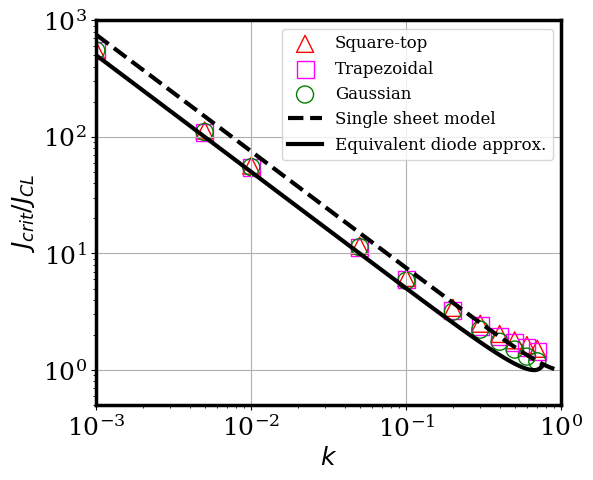

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(k_range,(2/3)*Jc_sq,marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(k_range,(2/3)*Jc_tr,marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(k_range,(2/3)*Jc_ga,marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')
# # ================================================================
# # plt.scatter(k_range,XOOPIC_square,marker='x',s=100,label='XOOPIC')
# plt.errorbar(k_range, XOOPIC_square, yerr=errors, fmt='^',color='r',label='PIC Square-top')
# plt.errorbar(k_range, XOOPIC_tr, yerr=errort, fmt='s',color='magenta',label='PIC Trapezoidal')
# plt.errorbar(k_range, XOOPIC_g, yerr=errorg, fmt='o',color='g',label='PIC Gaussian')
# ================================================================
plt.plot(Tau_val_s,Jcrit_s,'--',color='black',lw=3,label='Single sheet model')
plt.plot(Tau_val_e,Jcrit_e,'black',lw=3,label='Equivalent diode approx.')

# plt.text(.112, 7.25, '(a)', fontsize=26)
plt.ylabel('$J_{crit}/J_{CL}$')
plt.xlabel('$k$')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12)

plt.ylim(0.5,1e3)
plt.xlim(1e-3,1)
plt.grid()
# plt.savefig('current_limit.png',transparent=True,bbox_inches='tight', dpi=300)
plt.show()

## Energy distribution

In [ ]:
fp

2.8

In [ ]:
charge_mult = []
mass_mult = []
charge_mult.append(fp*Sq_charge)
charge_mult.append(fp*Tr_charge)
charge_mult.append(fp*Ga_charge)
mass_mult.append(fp*Sq_mass)
mass_mult.append(fp*Tr_mass)
mass_mult.append(fp*Ga_mass)

## k = 0.1

In [ ]:
fp = 2.
kp = .1
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(4,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_01 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(4500):
                if position_mult[v][j][i] >= p:
                    K.append(mass_mult[v][i]*velocity_mult[v][j][i] ** 2)
                    break
    EnK_01.append(K)

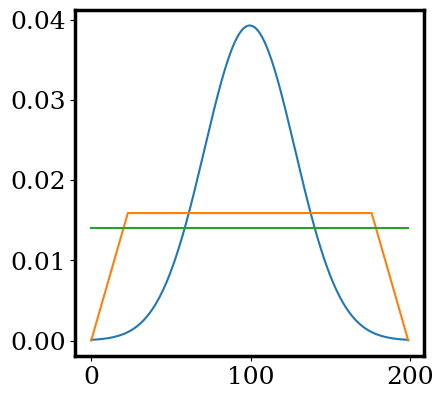

In [ ]:
plt.plot(mass_mult[2])
plt.plot(mass_mult[1])
plt.plot(mass_mult[0])

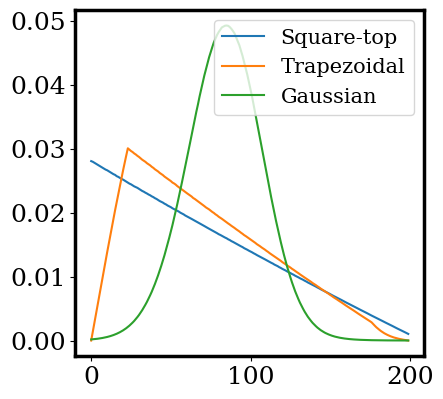

In [ ]:
plt.plot(EnK_01[0],label='Square-top')
plt.plot(EnK_01[1],label='Trapezoidal')
plt.plot(EnK_01[2],label='Gaussian')
plt.legend(fontsize=15)

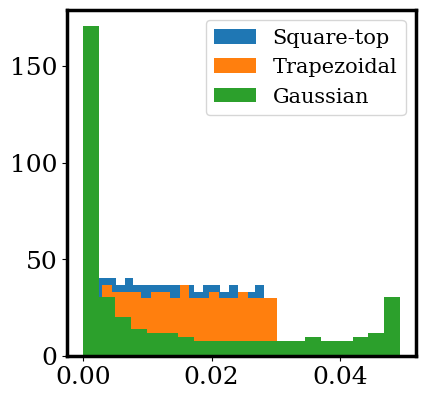

In [ ]:
plt.hist(np.array(EnK_01[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_01[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_01[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)

In [ ]:
max(EnK_01[1])-min(EnK_01[1])

0.030100519248269734

## k = 0.5

In [ ]:
fp = 2.8
kp = .5
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_05 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(1950):
                if position_mult[v][j][i] >= p:
                    K.append(velocity_mult[v][j][i] ** 2)
                    break
    EnK_05.append(K)

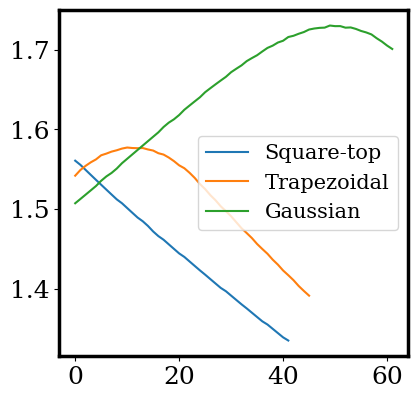

In [ ]:
plt.plot(EnK_05[0],label='Square-top')
plt.plot(EnK_05[1],label='Trapezoidal')
plt.plot(EnK_05[2],label='Gaussian')
plt.legend(fontsize=15)

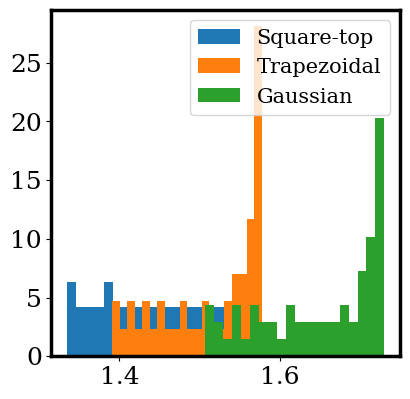

In [ ]:
plt.hist(np.array(EnK_05[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_05[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_05[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)

## k = 1

In [ ]:
fp = 2.8
kp = 1
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_1 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(1950):
                if position_mult[v][j][i] >= p:
                    K.append(velocity_mult[v][j][i] ** 2)
                    break
    EnK_1.append(K)

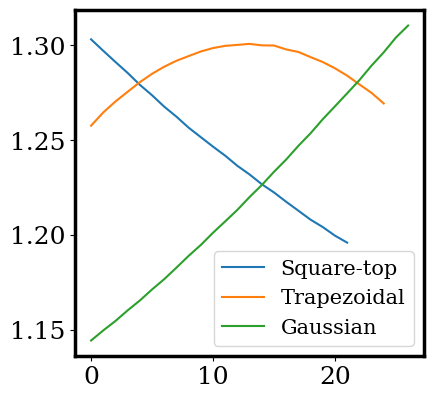

In [ ]:
plt.plot(EnK_1[0],label='Square-top')
plt.plot(EnK_1[1],label='Trapezoidal')
plt.plot(EnK_1[2],label='Gaussian')
plt.legend(fontsize=15)

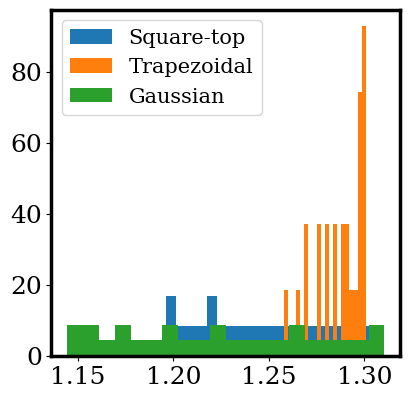

In [ ]:
plt.hist(np.array(EnK_1[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_1[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_1[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)